In [12]:
import os
from glob import glob
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import json
import torch

sns.set(context="paper", style="whitegrid", font_scale=1.5)
%matplotlib inline

## Setup

In [13]:
exp_name = "200911_mnist"
use_eval_runs = True
exp_type = "mnist"

In [14]:
train_files = f"../results/{exp_name}/*/config.json"
eval_files = f"../results/{exp_name}/*/eval/*/config.json"

In [15]:
if use_eval_runs:
    files = eval_files
else:
    files = train_files

In [16]:
if exp_type == "mnist":
    calibration_data = "rotated_mnist"
    ood_data = "fashion_mnist"
elif exp_type == "cifar10":
    calibration_data = "cifar10c"
    ood_data = "svhn"
else:
    raise ValueError(f"Unknown experiment type {exp_type}")

In [17]:
monolithic_priors = ["gaussian", "laplace", "student-t", "cauchy", "improper", "gennorm"]
hierarchical_priors = ["gaussian_gamma", "laplace_gamma", "student-t_gamma", "horseshoe", "mixture",
                       "gaussian_empirical", "laplace_empirical", "student-t_empirical", "gennorm_empirical"]

In [109]:
def plot_grid(runs, y, yerr=None, ylabel="performance", ylim=None, x="weight_prior", title=None, baseline=None):
    scales = sorted(runs.weight_scale.unique())
    temps = sorted(runs.temperature.unique())
    fig, axes = plt.subplots(len(scales), len(temps), sharex=True, sharey=True, figsize=(3*len(temps)+2,3*len(scales)+2))
    
    if len(scales) == 1:
        axes = [axes]

    for scale, axs in zip(scales, axes):
        if len(temps) == 1:
            axs = [axs]
        for temp, ax in zip(temps, axs):
            df = runs.sort_values([x, "weight_scale"]).query(f"weight_scale == {scale} & temperature == {temp}")
            df.plot(x=x, y=y, yerr=yerr, kind="bar", legend=False, ax=ax)
            ax.set_title(f"scale={scale} and T={temp}")
            ax.set_ylabel(ylabel)
            if ylim is not None:
                ax.set_ylim(ylim)
            if baseline is not None:
                ax.axhline(y=baseline, color="red", linestyle="dashed")
                
    if title is not None:
        fig.suptitle(title)
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    else:
        fig.tight_layout()

    return fig

## Load results

In [186]:
runs = []
for config_file in glob(files):
    with open(config_file) as infile:
        config = pd.Series(json.load(infile))
    with open(config_file[:-11] + "run.json") as infile:
        result = pd.Series(json.load(infile)["result"], dtype=np.float32)
    run_data = pd.concat([config, result])
    runs.append(run_data)
    if not use_eval_runs and run_data["weight_prior"] == "improper":
        print(run_data["weight_prior"], run_data["temperature"], run_data["weight_scale"], config_file)
runs_all = pd.concat(runs, axis=1).T

../results/200911_mnist/8/eval/3/config.json
../results/200911_mnist/8/eval/2/config.json
../results/200911_mnist/8/eval/1/config.json


In [111]:
runs_all["error_mean"] = 1. - runs_all["acc_mean"]

In [112]:
runs_all.head()

,accuracy_eval,batch_size,batchnorm,bias_loc,bias_prior,bias_prior_params,bias_scale,burnin,calibration_eval,config_file,...,lp_stderr,mean_loglik,simple_logmarglik,simple_marglik,ace,ece,rmsce,auprc,auroc,error_mean
0,True,128,True,0,gaussian,{},1,10,False,../results/200911_mnist/21/config.json,...,9.19093e-05,-1.80991e+11,-1.06434e+06,0,NaN,NaN,NaN,NaN,NaN,0.886544
1,True,128,True,0,gaussian,{},1,10,True,../results/200911_mnist/21/config.json,...,6.665e-05,NaN,NaN,NaN,0.0431121,0.00110658,0.009699,NaN,NaN,0.886619
2,True,128,True,0,gaussian,{},1,10,False,../results/200911_mnist/21/config.json,...,2.51147e-05,NaN,NaN,NaN,NaN,NaN,NaN,0.425357,0.361153,0.899583
3,True,128,True,0,gaussian,{},1,10,False,../results/200911_mnist/3/config.json,...,0.00554576,NaN,NaN,NaN,NaN,NaN,NaN,0.764262,0.77205,0.940999
4,True,128,True,0,gaussian,{},1,10,True,../results/200911_mnist/3/config.json,...,0.00065165,NaN,NaN,NaN,0.0298332,0.135211,0.0102865,NaN,NaN,0.2557


## Evaluate predictive performance

In [113]:
if use_eval_runs:
    runs_selected = runs_all.query("eval_data != eval_data")  # basically checks for None
else:
    runs_selected = runs_all

In [133]:
acc_baseline = 1 - runs_selected.query("weight_prior == 'improper' & temperature == 0.")["acc_last"].values[0]

In [134]:
lp_baseline = runs_selected.query("weight_prior == 'improper' & temperature == 0.")["lp_last"].values[0]

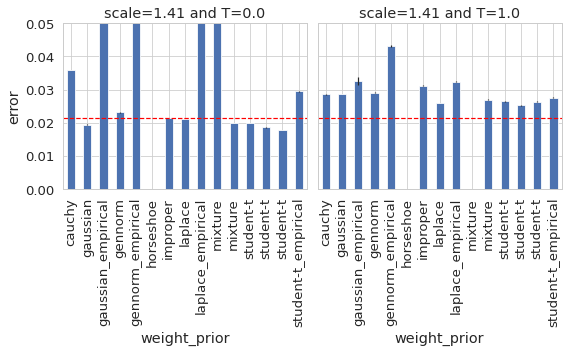

In [135]:
fig = plot_grid(runs_selected, y="error_mean", yerr="acc_stderr", ylabel="error", ylim=(0, 0.05), baseline=acc_baseline)

In [136]:
fig.savefig(f"../figures/{exp_name}_acc.pdf")

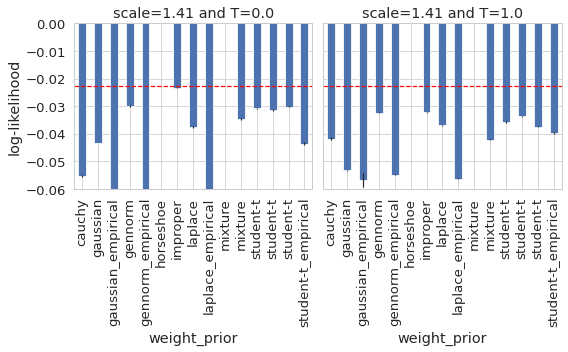

In [137]:
fig = plot_grid(runs_selected, y="lp_ensemble", yerr="lp_stderr", ylabel="log-likelihood", ylim=(-0.06, 0), baseline=lp_baseline)

In [138]:
fig.savefig(f"../figures/{exp_name}_ll.pdf")

In [139]:
runs_subselected = runs_selected.query(f"weight_prior in {monolithic_priors}")

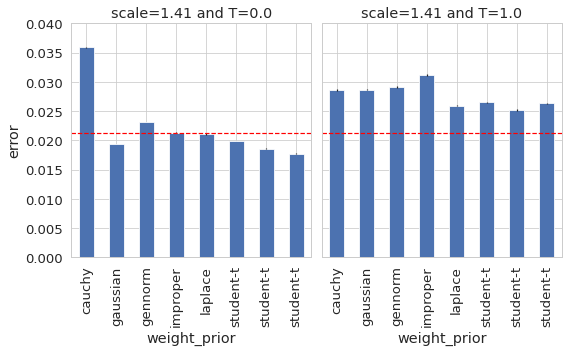

In [140]:
fig = plot_grid(runs_subselected, y="error_mean", yerr="acc_stderr", ylabel="error", ylim=(0, 0.04), baseline=acc_baseline)

In [141]:
fig.savefig(f"../figures/{exp_name}_acc_monolithic.pdf")

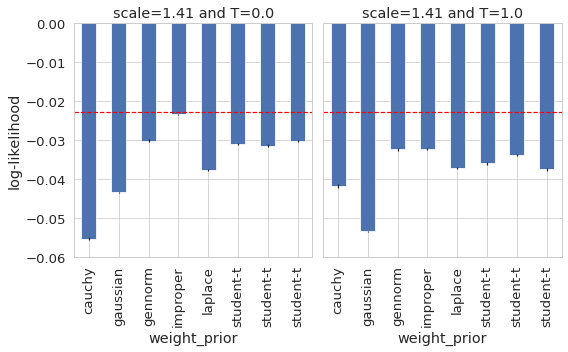

In [142]:
fig = plot_grid(runs_subselected, y="lp_ensemble", yerr="lp_stderr", ylabel="log-likelihood", ylim=(-0.06, 0), baseline=lp_baseline)

In [143]:
fig.savefig(f"../figures/{exp_name}_ll_monolithic.pdf")

In [144]:
runs_subselected = runs_selected.query(f"weight_prior in {hierarchical_priors}")

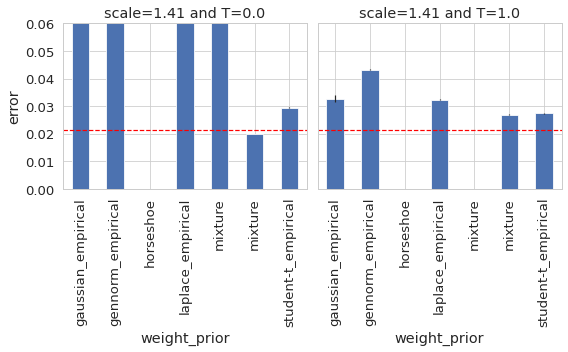

In [145]:
fig = plot_grid(runs_subselected, y="error_mean", yerr="acc_stderr", ylabel="error", ylim=(0, 0.06), baseline=acc_baseline)

In [146]:
fig.savefig(f"../figures/{exp_name}_acc_hierarchical.pdf")

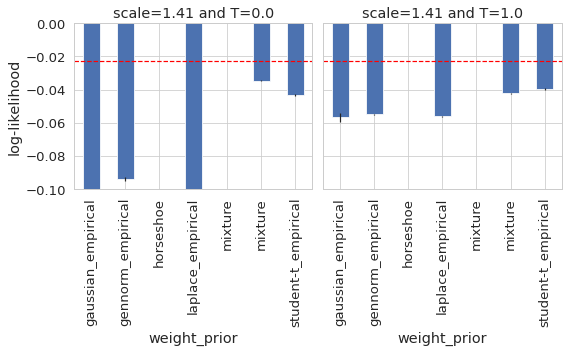

In [147]:
fig = plot_grid(runs_subselected, y="lp_ensemble", yerr="lp_stderr", ylabel="log-likelihood", ylim=(-0.1, 0), baseline=lp_baseline)

In [148]:
fig.savefig(f"../figures/{exp_name}_ll_hierarchical.pdf")

## Evaluate mixture models

In [149]:
skip = -50

df_mixture = pd.DataFrame(columns=["weight_scale", "temperature", "layer", "component", "weight", "log_weight"])

for config_file in glob(train_files):
    with open(config_file) as infile:
        config = pd.Series(json.load(infile))
    if config["weight_prior"] == "mixture":
        components = config["weight_prior_params"]["components"].split("_")
        samples_file = os.path.join(os.path.dirname(config_file),"samples.pt")
        if not os.path.exists(samples_file):
            continue
        samples = torch.load(samples_file)
        mixture_weights = {k[:5]:torch.nn.functional.softmax(v[skip:], dim=1).mean(0).detach().numpy()
                   for k, v in samples.items() if "mixture_weights" in k}
        scale = config['weight_scale']
        temp = config['temperature']
        for layer, weights in mixture_weights.items():
            for comp, weight in zip(components, weights):
                df_mixture.loc[len(df_mixture)] = [scale, temp, layer, comp, weight, np.log(weight)]

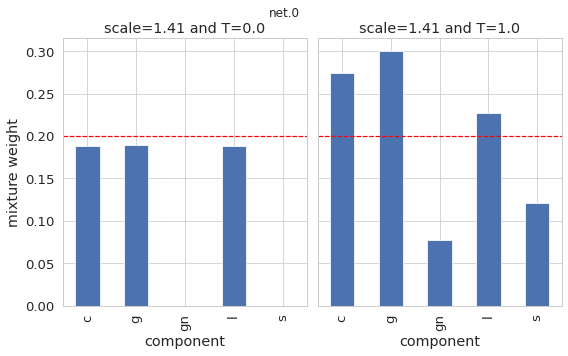

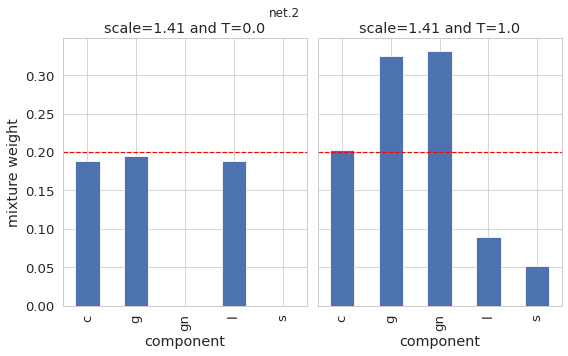

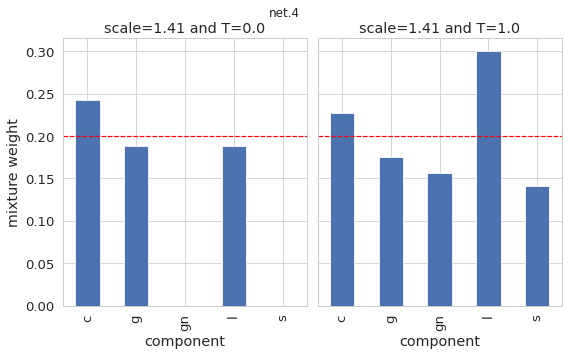

In [150]:
with PdfPages(f"../figures/{exp_name}_mixture_weights.pdf") as pdf:
    for layer in df_mixture.layer.unique():
        fig = plot_grid(df_mixture.query(f"layer == '{layer}'"), y="weight", ylabel="mixture weight", x="component", title=f"{layer}", baseline=0.2)
        pdf.savefig()

## Evaluate marginal likelihood

In [151]:
assert use_eval_runs, "The marginal likelihood, calibration, and OOD can only be assessed on eval data"

In [152]:
runs_selected = runs_selected[runs_selected.weight_prior.apply(lambda val: val not in ["improper", "uniform", "mixture"])]

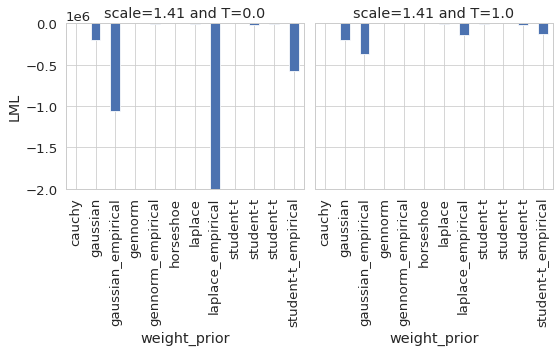

In [153]:
fig = plot_grid(runs_selected, y="simple_logmarglik", ylabel="LML", ylim=(-2e6, 0.))

In [154]:
fig.savefig(f"../figures/{exp_name}_logmargliks.pdf")

In [155]:
runs_subselected = runs_selected.query(f"weight_prior in {monolithic_priors}")

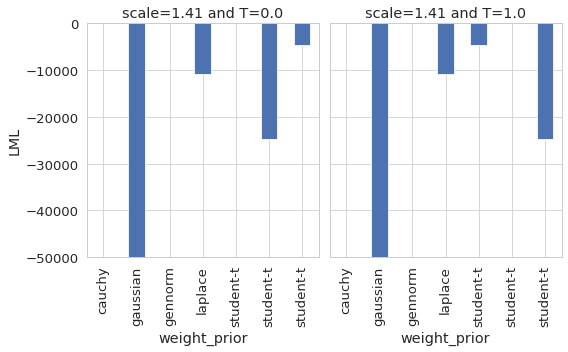

In [156]:
fig = plot_grid(runs_subselected, y="simple_logmarglik", ylabel="LML", ylim=(-5e4, 0.))

In [157]:
fig.savefig(f"../figures/{exp_name}_logmargliks_monolithic.pdf")

In [158]:
margliks = runs_selected["simple_logmarglik"].values.astype(float)
lls = runs_selected["lp_mean"].values.astype(float)
accs = runs_selected["acc_mean"].values.astype(float)

In [159]:
print("Correlation between log marginal likelihoods and test log likelihoods:")
print("Pearson's r = {0:.3f} with p-value = {1:.2e}".format(*stats.pearsonr(margliks, lls)))
print("Spearman's rho = {0:.3f} with p-value = {1:.2e}".format(*stats.spearmanr(margliks, lls)))
print("Kendall's tau = {0:.3f} with p-value = {1:.2e}".format(*stats.kendalltau(margliks, lls)))

print("Correlation between log marginal likelihoods and test errors:")
print("Pearson's r = {0:.3f} with p-value = {1:.2e}".format(*stats.pearsonr(margliks, accs)))
print("Spearman's rho = {0:.3f} with p-value = {1:.2e}".format(*stats.spearmanr(margliks, accs)))
print("Kendall's tau = {0:.3f} with p-value = {1:.2e}".format(*stats.kendalltau(margliks, accs)))

Correlation between log marginal likelihoods and test log likelihoods:


ValueError: array must not contain infs or NaNs

In [ ]:
priors = runs_selected.weight_prior.unique()
for prior in priors:
    print(f"Testing {prior} prior")

    runs_subselected = runs_selected.query(f"weight_prior == '{prior}'")
    margliks = runs_subselected["simple_logmarglik"].values.astype(float)
    lls = runs_subselected["lp_mean"].values.astype(float)
    accs = runs_subselected["acc_mean"].values.astype(float)

    print("Correlation between log marginal likelihoods and test log likelihoods:")
    print("Pearson's r = {0:.3f} with p-value = {1:.2e}".format(*stats.pearsonr(margliks, lls)))
    print("Spearman's rho = {0:.3f} with p-value = {1:.2e}".format(*stats.spearmanr(margliks, lls)))
    print("Kendall's tau = {0:.3f} with p-value = {1:.2e}".format(*stats.kendalltau(margliks, lls)))

    print("Correlation between log marginal likelihoods and test errors:")
    print("Pearson's r = {0:.3f} with p-value = {1:.2e}".format(*stats.pearsonr(margliks, accs)))
    print("Spearman's rho = {0:.3f} with p-value = {1:.2e}".format(*stats.spearmanr(margliks, accs)))
    print("Kendall's tau = {0:.3f} with p-value = {1:.2e}".format(*stats.kendalltau(margliks, accs)))
    print("")

## Evaluate calibration

In [160]:
runs_selected = runs_all.query(f"'{calibration_data}' in eval_data")

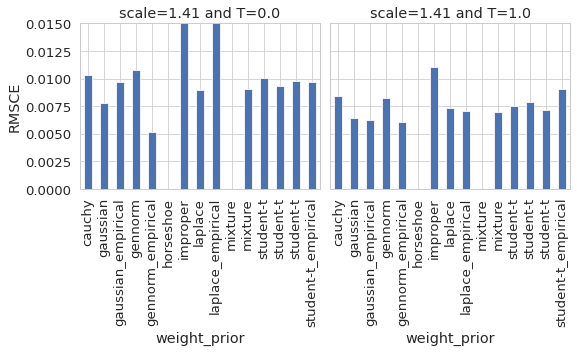

In [161]:
fig = plot_grid(runs_selected, y="rmsce", ylabel="RMSCE", ylim=(0, 0.015))

In [162]:
fig.savefig(f"../figures/{exp_name}_rmsce.pdf")

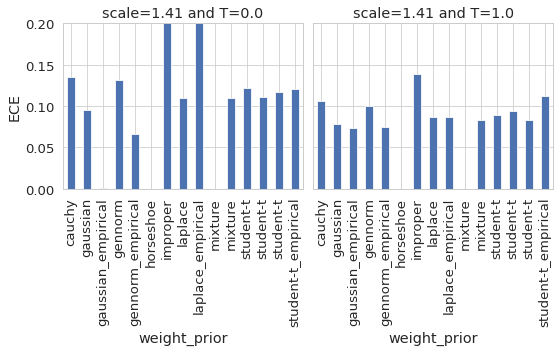

In [163]:
fig = plot_grid(runs_selected, y="ece", ylabel="ECE", ylim=(0, 0.2))

In [164]:
fig.savefig(f"../figures/{exp_name}_ece.pdf")

In [165]:
runs_subselected = runs_selected.query(f"weight_prior in {monolithic_priors}")

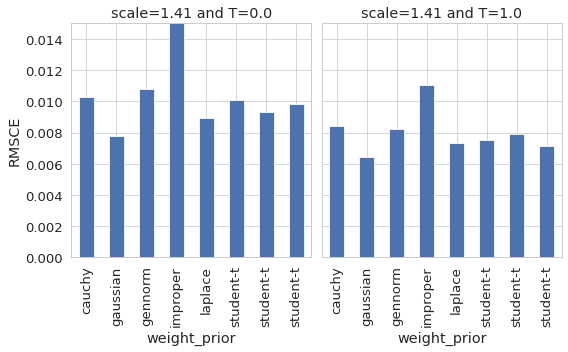

In [166]:
fig = plot_grid(runs_subselected, y="rmsce", ylabel="RMSCE", ylim=(0, 0.015))

In [167]:
fig.savefig(f"../figures/{exp_name}_rmsce_monolithic.pdf")

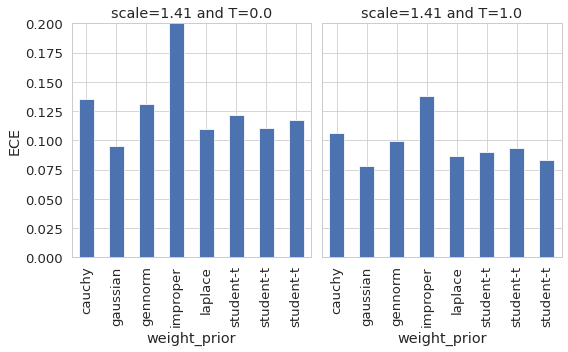

In [168]:
fig = plot_grid(runs_subselected, y="ece", ylabel="ECE", ylim=(0, 0.2))

In [169]:
fig.savefig(f"../figures/{exp_name}_ece_monolithic.pdf")

## Evaluate OOD detection

In [170]:
runs_selected = runs_all.query(f"'{ood_data}' in eval_data")

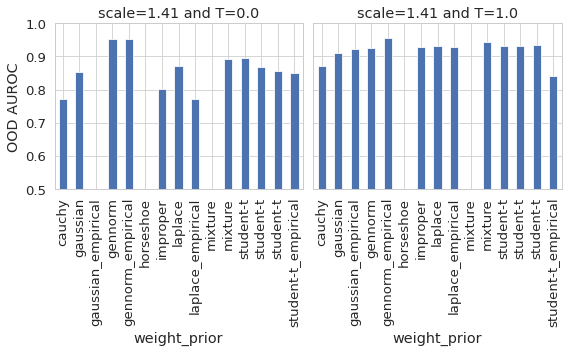

In [171]:
fig = plot_grid(runs_selected, y="auroc", ylabel="OOD AUROC", ylim=(0.5, 1.))

In [172]:
fig.savefig(f"../figures/{exp_name}_ood.pdf")

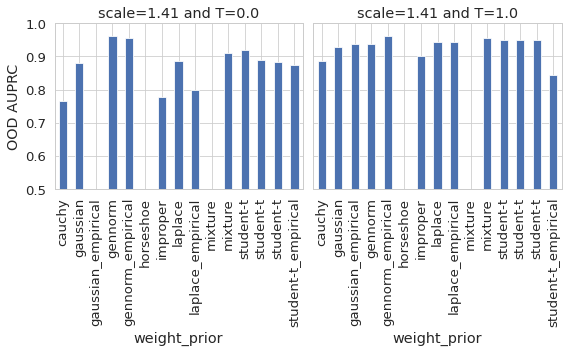

In [173]:
fig = plot_grid(runs_selected, y="auprc", ylabel="OOD AUPRC", ylim=(0.5, 1.))

In [174]:
fig.savefig(f"../figures/{exp_name}_ood.pdf")

In [175]:
runs_subselected = runs_selected.query(f"weight_prior in {monolithic_priors}")

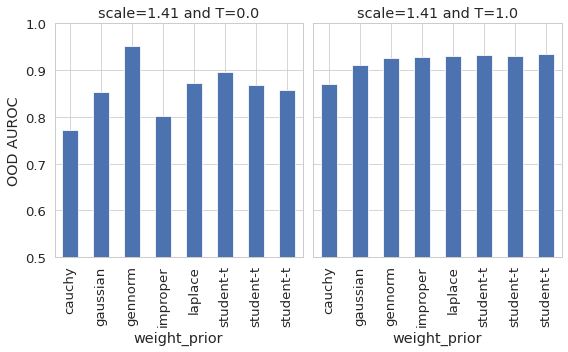

In [176]:
fig = plot_grid(runs_subselected, y="auroc", ylabel="OOD AUROC", ylim=(0.5, 1.))

In [177]:
fig.savefig(f"../figures/{exp_name}_ood_monolithic.pdf")

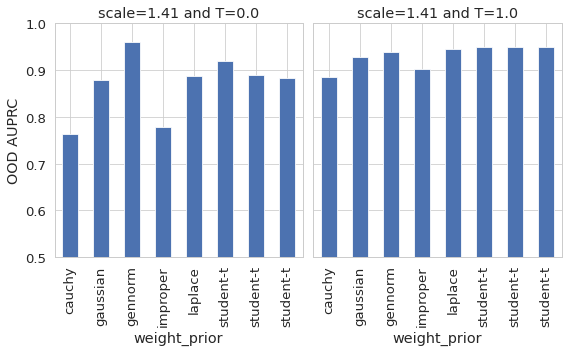

In [178]:
fig = plot_grid(runs_subselected, y="auprc", ylabel="OOD AUPRC", ylim=(0.5, 1.))

In [179]:
fig.savefig(f"../figures/{exp_name}_ood_monolithic.pdf")

## Evaluate empirical distribution of weights

In [180]:
# Adapted from https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python

import scipy.stats as st
import warnings
import tqdm

# Create models from data
def best_fit_distribution(data, bins=200):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [st.cauchy,st.gennorm,st.laplace,st.norm,st.t]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf
    
    sses = {}

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                sses[distribution.name] = sse

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            f"Failed to fit {distribution}"

    return (best_distribution.name, best_params, sses)

In [181]:
final_weights = None
for config_file in glob(train_files):
    with open(config_file) as infile:
        config = pd.Series(json.load(infile))
    if config["weight_prior"] == "improper":
        samples = torch.load(os.path.join(os.path.dirname(config_file),"samples.pt"))
        final_weights_sample = {param : val[-1] for param, val in samples.items() if "weight_prior.p" in param}
        if final_weights is None:
            final_weights = final_weights_sample
        else:
            final_weights = {param: torch.cat((final_weights[param], val)) for param, val in final_weights_sample.items()}
final_weights = {param: val.detach().numpy().flatten() for param, val in final_weights.items()}

net.0.weight_prior.p t (0.910584718446428, 0.003287055893423249, 0.10539704188903487)
net.2.weight_prior.p cauchy (0.0008210528674457108, 0.20995993171158678)
net.4.weight_prior.p gennorm (1.5437234349534366, -0.011839198766045441, 0.6640410847131296)


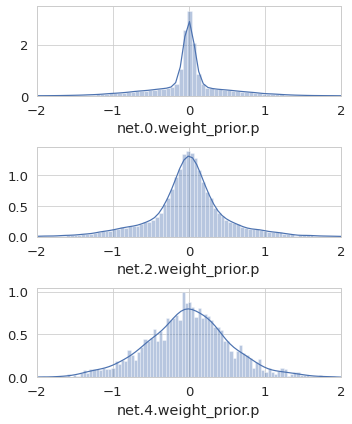

In [182]:
layer_fits = {}
fig, axs = plt.subplots(nrows=len(final_weights), figsize=(5, 2*len(final_weights)))
for (param, weights), ax in zip(final_weights.items(), axs):
    sns.distplot(weights, ax=ax, bins=100)
    ax.set_xlabel(param)
    ax.set_xlim((-2, 2))
    best_fit_name, best_fit_params, sses = best_fit_distribution(weights, 200)
    print(param, best_fit_name, best_fit_params)
    layer_fits[param] = {k: v for i, (k, v) in enumerate(sorted(sses.items(), key=lambda item: item[1])) if i<5}
fig.tight_layout()

In [183]:
fig.savefig(f"../figures/{exp_name}_empirical_weightdist.pdf")

In [184]:
for param, fits in layer_fits.items():
    print(f"Best fit for {param} weigths: ",", ".join([f"{dist} ({err:.2f})" for dist, err in fits.items()]))

Best fit for net.0.weight_prior.p weigths:  t (2.28), gennorm (2.54), cauchy (2.96), laplace (12.23), norm (25.62)
Best fit for net.2.weight_prior.p weigths:  cauchy (0.29), gennorm (0.31), laplace (0.37), t (0.55), norm (4.26)
Best fit for net.4.weight_prior.p weigths:  gennorm (1.07), t (1.16), norm (1.37), laplace (1.67), cauchy (2.20)


In [185]:
for param, weight in final_weights.items():
    print(f"Normality tests for {param}:")
    print(f"Mean = {weight.mean():.2f}, std = {weight.flatten().std():.2f}")
    print("D'Angostino: statistic = {0:.2f}, p-value = {1:.2e}".format(*stats.normaltest(weight)))
    print("Shapiro: statistic = {0:.2f}, p-value = {1:.2e}".format(*stats.shapiro(np.random.choice(weight, size=min(5000, len(weight)), replace=False))))

Normality tests for net.0.weight_prior.p:
Mean = -0.00, std = 0.46
D'Angostino: statistic = 11093.97, p-value = 0.00e+00
Shapiro: statistic = 0.91, p-value = 0.00e+00
Normality tests for net.2.weight_prior.p:
Mean = -0.01, std = 0.50
D'Angostino: statistic = 1041.84, p-value = 5.85e-227
Shapiro: statistic = 0.96, p-value = 6.94e-35
Normality tests for net.4.weight_prior.p:
Mean = -0.02, std = 0.56
D'Angostino: statistic = 14.67, p-value = 6.53e-04
Shapiro: statistic = 1.00, p-value = 5.57e-05
